In [17]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), '..')))
import flares

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr
from matplotlib.colors import Normalize
from scipy.stats import binned_statistic
from unyt import erg, s, Angstrom

from synthesizer.grid import Grid
from synthesizer.emission_models.agn.models import DiscIncidentEmission
from synthesizer.particle import BlackHoles

from flares_utility.stats import weighted_median, binned_weighted_quantile

# Set a random number seed to ensure consistent results
np.random.seed(42)

In [18]:
# set style
plt.style.use('../matplotlibrc.txt')

## get data

In [19]:
tag = flares.tags[-1]
print(tag)
quantities = flares.get_quantities(tag, group='details')

blackhole_mass = quantities['blackhole_masses'].to('Msun')
blackhole_accretion_rate = quantities['accretion_rates']['10'].to('Msun/yr')
bolometric_luminosity = quantities['bolometric_luminosities']['10']
eddington_ratio = quantities['eddington_ratios']['10']
weights = quantities['weights']
stellar_halpha_luminosity = quantities['attenuated_stellar_halpha_luminosity'] * erg/s
intrinsic_stellar_halpha_luminosity = quantities['intrinsic_stellar_halpha_luminosity'] * erg/s
stellar_halpha_ew = quantities['attenuated_stellar_halpha_ew'] * Angstrom
intrinsic_stellar_halpha_ew = quantities['intrinsic_stellar_halpha_ew'] * Angstrom

# print(blackhole_mass)
print('total number of BHs', len(blackhole_mass))

selection = (blackhole_mass.to('Msun').value > 1E6) & (bolometric_luminosity.to('erg/s').value > 1E44)

selection = bolometric_luminosity.to('erg/s').value > 1E30

print(np.sum(selection))

stellar_halpha_ew = stellar_halpha_ew[selection]
intrinsic_stellar_halpha_ew = intrinsic_stellar_halpha_ew[selection]
stellar_halpha_luminosity = stellar_halpha_luminosity[selection]
intrinsic_stellar_halpha_luminosity = intrinsic_stellar_halpha_luminosity[selection]
blackhole_mass = blackhole_mass[selection]
blackhole_accretion_rate = blackhole_accretion_rate[selection]
bolometric_luminosity = bolometric_luminosity[selection]
weights = weights[selection]

conservative_selection = (blackhole_mass.to('Msun').value > 1E7) & (bolometric_luminosity.to('erg/s').value > 1E45)

print(np.sum(conservative_selection))


selection_label = r'$\rm M_{\bullet}>10^{6}\ M_{\odot}, L_{\rm bol}>10^{44}\ {\rm erg\ s^{-1}}$'
conservative_selection_label = r'$\rm M_{\bullet}>10^{7}\ M_{\odot}, L_{\rm bol}>10^{45}\ {\rm erg\ s^{-1}}$'



stellar_halpha_continuum = stellar_halpha_luminosity / stellar_halpha_ew
intrinsic_stellar_halpha_continuum = intrinsic_stellar_halpha_luminosity / intrinsic_stellar_halpha_ew



010_z005p000
total number of BHs 237437
6405
153


First we need to initialise our `BlackHole` object with the parameters that will be needed to compute spectra.

In [20]:

blackholes = BlackHoles(
    masses=blackhole_mass,
    accretion_rates=blackhole_accretion_rate,
)

In [21]:

grid_name = 'qsosed-isotropic'
grid_dir = "/Users/sw376/Dropbox/Research/data/synthesizer/grids/"

grid = Grid(
    grid_name=grid_name, 
    grid_dir=grid_dir,
    read_lines=False)

In [22]:

emission_model = DiscIncidentEmission(grid)


In [23]:
# get the spectra assuming this emission model
blackholes.get_particle_spectra(emission_model)

# short-hand    
spectra = blackholes.particle_spectra['disc_incident']

In [24]:

ionising_photon_luminosity = spectra.calculate_ionising_photon_production_rate()

ionising_bolometric_correction = ionising_photon_luminosity/spectra.bolometric_luminosity

halpha_luminosity = ionising_photon_luminosity * flares.ionising_to_Halpha_conversion

print(np.min(halpha_luminosity), np.max(halpha_luminosity))

# measure continuum at h-alpha


4.9389180999917167e+36 erg/s 2.7314033032270022e+45 erg/s


## select $f_{BLR}$ of AGN

In [25]:
f_blr = 0.75

ntot = len(halpha_luminosity)
print(f'total: {ntot}')

size = int(ntot * f_blr)
print(f'selected: {size}')

# this is the better way of doing the selection
fblr_selection = np.zeros(ntot, dtype=bool)
fblr_selection[np.random.choice(np.arange(0, ntot), size=size, replace=False)] = True

print(f'selection: {np.sum(fblr_selection)} {len(fblr_selection)} {np.sum(fblr_selection)/len(fblr_selection)}')


total: 6405
selected: 4803
selection: 4803 6405 0.7498829039812647


In [26]:

from scipy.interpolate import interp1d


print(spectra.lam.shape)
print(spectra.llam.shape)

halpha_continuum = interp1d(spectra.lam.to('Angstrom').value, spectra.llam.to('erg/s/Angstrom').value)(6563.) * erg/s/Angstrom 

halpha_ew = halpha_luminosity / halpha_continuum

print(np.min(halpha_ew[conservative_selection]), np.median(halpha_ew[conservative_selection]), np.max(halpha_ew[conservative_selection]))

(1999,)
(6405, 1999)
376.54258632655586 Å 5694.110926840469 Å 14342.743156602502 Å


## EW vs. luminosity

In [27]:
norm = Normalize(vmin=7., vmax=9.5)
cmap = cmr.bubblegum
n = norm

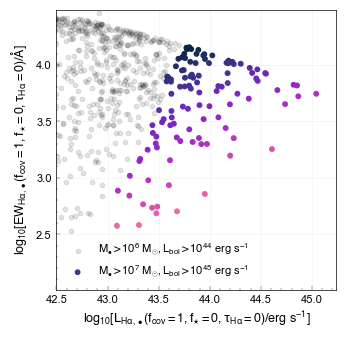

In [35]:
xlimits = np.array([42.5, 45.24])  # log10(erg/s)
ylimits = np.array([2.01, 4.49])
 

fig = plt.figure(figsize = (3.5, 3.5))

left  = 0.15
height = 0.8
bottom = 0.15
width = 0.8


ax = fig.add_axes((left, bottom, width, height))

ax.scatter(np.log10(halpha_luminosity.to('erg/s').value[fblr_selection]), 
           np.log10(halpha_ew.to('Angstrom').value[fblr_selection]), 
           alpha=0.1, 
           c='k', 
           s=10,
           label=selection_label)

ax.scatter(np.log10(halpha_luminosity.to('erg/s').value[(fblr_selection)&(conservative_selection)]), 
           np.log10(halpha_ew.to('Angstrom').value[(fblr_selection)&(conservative_selection)]),
           s=10,
           color=cmap(norm(np.log10(blackholes.masses.to('Msun').value[(fblr_selection)&(conservative_selection)]))),
           label=conservative_selection_label)


ax.set_xlim(xlimits)
ax.set_ylim(ylimits)
ax.set_yticks([2.5, 3.0, 3.5, 4.0])
# ax.set_yscale('log')


# ax.set_ylabel(r'$\rm EW_{H\alpha}(f_{\rm cov}=1)/\AA$')
ax.set_ylabel(r'$\rm log_{10}[EW_{H\alpha, \bullet}(f_{\rm cov}=1, f_{\star}=0, \tau_{H\alpha}=0)/\AA]$')
ax.set_xlabel(r'$\rm log_{10}[L_{H\alpha, \bullet}(f_{cov}=1, f_{\star}=0, \tau_{H\alpha}=0)/erg\ s^{-1}]$')

# ax.text(1., 37, r'$\rm M_{\bullet}>10^{7}\ M_{\odot}, L_{\rm bol}>10^{44}\ {\rm erg\ s^{-1}}$', fontsize=8)

ax.legend(fontsize=8)

filename = f'figures/agn_ew.pdf'
fig.savefig(filename)
plt.show()
fig.clf()

## EW distribution

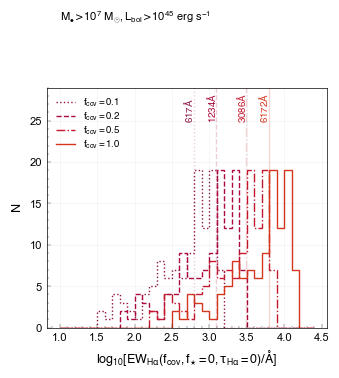

In [38]:

# xlimits = np.array([42.01, 44.75])  # log10(erg/s)
# ylimits = np.array([-7., 2.99])
 

fig = plt.figure(figsize = (3.5, 3.))

left  = 0.15
height = 0.8
bottom = 0.15
width = 0.8


ax = fig.add_axes((left, bottom, width, height))

bins = np.arange(1., 4.5, 0.1)

colours = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.4, 0.6))

for fcov, ls, col in zip([0.1, 0.2, 0.5, 1.0], [':', '--','-.', '-',], colours):

    # N, bin_edges = np.histogram(np.log10(fcov*halpha_ew[conservative_selection]), bins=bins, weights=weights[conservative_selection])
    N, bin_edges = np.histogram(np.log10(fcov*halpha_ew[(fblr_selection)&(conservative_selection)]), bins=bins)
    median = np.median(np.log10(fcov*halpha_ew.to('Angstrom').value[(fblr_selection)&(conservative_selection)]))
    ax.axvline(median, c=col, lw=1, alpha=0.2, ls=ls)
    ax.text(median-0.15, 25., rf'$\rm {10**median:.0f}\AA$', rotation=90., fontsize=7, color=col)
    ax.stairs(N, bin_edges, ls=ls, color=col, label=fr'$\rm f_{{cov}}={fcov}$')


# ax.set_xlim(xlimits)
ax.set_ylim([0, 29.])

ax.set_xlabel(r'$\rm log_{10}[EW_{H\alpha}(f_{cov}, f_{\star}=0, \tau_{H\alpha}=0)/\AA]$')
ax.set_ylabel(r'$\rm N$')

ax.text(1., 37, conservative_selection_label, fontsize=8)
ax.legend(fontsize=7, labelspacing=0.15)



filename = f'figures/agn_ew_distribution.pdf'
fig.savefig(filename)
plt.show()
fig.clf()






## AGN vs. total EW

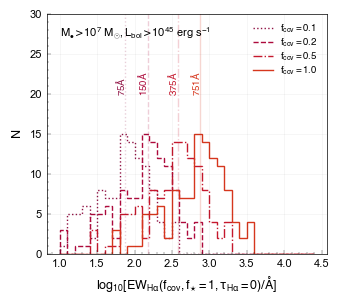

In [44]:
halpha_ew_wstellar = halpha_luminosity / (halpha_continuum + intrinsic_stellar_halpha_continuum)

fig = plt.figure(figsize = (3.5, 3.))

left  = 0.15
height = 0.8
bottom = 0.15
width = 0.8


ax = fig.add_axes((left, bottom, width, height))

bins = np.arange(1., 4.5, 0.1)

colours = cmr.take_cmap_colors('cmr.ember', 3, cmap_range=(0.4, 0.6))


colours = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.4, 0.6))

for fcov, ls, col in zip([0.1, 0.2, 0.5, 1.0], [':', '--','-.', '-',], colours):

    # N, bin_edges = np.histogram(np.log10(fcov*halpha_ew[conservative_selection]), bins=bins, weights=weights[conservative_selection])
    N, bin_edges = np.histogram(np.log10(fcov*halpha_ew_wstellar[(fblr_selection)&(conservative_selection)]), bins=bins)
    median = np.median(np.log10(fcov*halpha_ew_wstellar.to('Angstrom').value[(fblr_selection)&(conservative_selection)]))
    ax.axvline(median, c=col, lw=1, alpha=0.2, ls=ls)
    ax.text(median-0.15, 20, rf'$\rm {10**median:.0f}\AA$', rotation=90., fontsize=7, color=col)
    ax.stairs(N, bin_edges, ls=ls, color=col, label=fr'$\rm f_{{cov}}={fcov}$')


# ax.set_xlim(xlimits)
ax.set_ylim([0, 30.])

ax.set_xlabel(r'$\rm log_{10}[EW_{H\alpha}(f_{cov}, f_{\star}=1, \tau_{H\alpha}=0)/\AA]$')
ax.set_ylabel(r'$\rm N$')

ax.text(1., 27, conservative_selection_label, fontsize=8)
ax.legend(fontsize=7, labelspacing=0.15)



filename = f'figures/agn_ew_distribution_wstellar.pdf'
fig.savefig(filename)
plt.show()
fig.clf()
